In [1]:
import pandas as pd
import numpy as np
from pathlib import Path
import os 
from datetime import timedelta
import os
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score, accuracy_score, confusion_matrix, r2_score
from sklearn.metrics import log_loss,auc,classification_report,roc_auc_score, roc_curve
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler, label_binarize
from sklearn import tree
import graphviz

from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.ensemble import RandomForestClassifier


pd.set_option('display.max_columns', None)
%matplotlib inline


In [2]:
import sys
sys.path.append("..")
from ICM_utils import helper, evaluation, metrics

/Users/patricfulop/anaconda3/envs/cancer/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


## 1. Amelia imputed dataset using no censoring (full data)
* Done: GBM treatment is separate, not doing very well
* Ongoing: TSNE visualization
* Ongoing: Understand what classes get confused

* Ongoing: Run on missing dataset
* Ongoing: Split the data into categories based on Alex's clustering 
           Rather than doing this, I suggest we try to classify based on your clusters directly.
* Ongoing: What is a good baseline for Marc? 
* Red: What about the Cox survival analysis model that people have been applying?

In [3]:
IMC_basedir = os.getcwd().split('code')[0]
DATA_Amelia_FILE = os.path.join(IMC_basedir, 'data/imputed_dataset_no_censoring_26022018_Amelia1.csv')
DATA_MICE_FILE = os.path.join(IMC_basedir, 'data/imputed_dataset_no_censoring_26022018_MICE.csv')
TRAIN_FILE = os.path.join(IMC_basedir, 'data/amelia_train')
TEST_FILE = os.path.join(IMC_basedir, 'data/amelia_test')
MODEL_DIR = os.path.join(IMC_basedir, 'data/amelia_model')

In [5]:
df_amelia = pd.read_csv(DATA_Amelia_FILE)
df_mice = pd.read_csv(DATA_MICE_FILE)

In [6]:
df_amelia.drop("Unnamed: 0", axis = 1, inplace=True)
df_mice.drop("Unnamed: 0", axis = 1, inplace=True)

In [7]:
df_amelia.head(2)

,Gender,Tumor_type,Tumor_grade,Gene_P53,Gene_Mgmt,Gene_Egfr,Gene_Mdm2,Gene_Cdk4,Gene_P16,Gene_Ihc_Atrx,Gene_Ch10Q,Gene_Ch9P,Tumor_Location,Tumor_Position,Surgery_type,Age_surgery,life_expectancy,IDH,TERT,IDH_TERT,X1p19q_codel,IK
0,M,gliome,3,NC,METHYLE,NORMAL,NORMAL,NORMAL,DELETE,Maintien,PERTE,NON PERTE,A,G,partielle,42,30,mutant,wt,3,0,90.512838
1,M,astrocytome,2,NC,NON METHYLE,NORMAL,NORMAL,NORMAL,NORMAL,extinction,NON PERTE,NON PERTE,N,non précisé,exérèse,28,2069,NC,wt,2,0,90.596534


In [8]:
df_amelia.shape

(2086, 22)

In [11]:
# Check for null values - no need here thanks to Alex and Amelia with its mouse
#for col in df_mice.columns:
 #   print('{0}\n  {1}\n'.format(col,df_mice[col].isnull().value_counts()))
# df_1 = df_small.dropna(axis=0, how='any')    

(array([1.572e+03, 2.490e+02, 1.330e+02, 5.900e+01, 3.500e+01, 1.500e+01,
        1.200e+01, 6.000e+00, 4.000e+00, 1.000e+00]),
 array([1.00000e+00, 1.16890e+03, 2.33680e+03, 3.50470e+03, 4.67260e+03,
        5.84050e+03, 7.00840e+03, 8.17630e+03, 9.34420e+03, 1.05121e+04,
        1.16800e+04]),
 <a list of 10 Patch objects>)

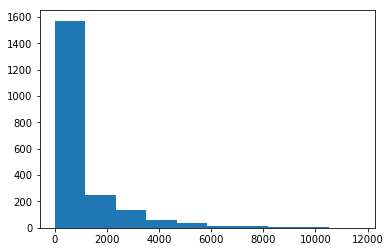

In [9]:
plt.hist(df_amelia.life_expectancy,bins =10)

## Split the predictor into 3 classes based on Alex's Clustering
* Automatic split
* 3 classes 
* 5 classes

In [10]:
# Try with three classes first based on Alex's clustering
labels = ["1.2years","4years","more"]
cut_points = [400,1200]
# labels = ["6months","1.2year","2years","3years","more"]
# cut_points = [200,400,700,1100]
#labels = ["3_months","6_months","9_months","12_months","15_months","18_months","2_years","3_years","4_years","5_years","10_years","10_plus_years"]
#cut_points = [90,180,270,360,450,540,720,1095,1460,1825,3650]

df_amelia.loc[:,"life_expectancy_bin"] = helper.binning(df_amelia.life_expectancy, cut_points, labels)
print(pd.value_counts(df_amelia.life_expectancy_bin, sort=False))

1.2years    703
4years      880
more        503
Name: life_expectancy_bin, dtype: int64


In [11]:
df_amelia.life_expectancy_bin.values

[1.2years, more, 1.2years, 1.2years, 4years, ..., 1.2years, 1.2years, 1.2years, more, 1.2years]
Length: 2086
Categories (3, object): [1.2years < 4years < more]

Below plot just shows relation between variables and predictor as pairplot (joint distribution)
Should be able to do this for everything
* Observe how for tumor grade 4 the blue part is highly likely - you'll leave less then 1.5 years unfortunately. 
* Looking at life expectancy and age surgery we see no obvious relationship, other than it's slightly to the left, so younger patients should live longer. 
* For IK it's the exact opposite, it seems that patients with IK will survive longer

In [15]:
#g = sns.pairplot(data=df_amelia,hue='life_expectancy_bin',size=3,kind='scatter')

## Display all posibilities  for each dataset 

In [12]:
for column in df_amelia:
    unique_vals = np.unique(df_amelia[column])
    nr_vals = len(unique_vals)
    if nr_vals < 20:
        print('Number of values for attribute {}: {} -- {}'.format(column, nr_vals, unique_vals))
    else:
        print('Number of values for attribute {}: {}'.format(column, nr_vals))

Number of values for attribute Gender: 2 -- ['F' 'M']
Number of values for attribute Tumor_type: 7 -- ['GBM' 'astrocytome' 'astrocytome gémistocytique (=A2)'
 'astrocytome pilocytique' 'gangliogliome' 'gliome' 'oligo']
Number of values for attribute Tumor_grade: 4 -- [1 2 3 4]
Number of values for attribute Gene_P53: 3 -- ['ALTERE' 'NC' 'NORMAL']
Number of values for attribute Gene_Mgmt: 2 -- ['METHYLE' 'NON METHYLE']
Number of values for attribute Gene_Egfr: 2 -- ['AMPLIFIE' 'NORMAL']
Number of values for attribute Gene_Mdm2: 2 -- ['AMPLIFIE' 'NORMAL']
Number of values for attribute Gene_Cdk4: 2 -- ['AMPLIFIE' 'NORMAL']
Number of values for attribute Gene_P16: 2 -- ['DELETE' 'NORMAL']
Number of values for attribute Gene_Ihc_Atrx: 3 -- ['Extinction diffuse' 'Maintien' 'extinction']
Number of values for attribute Gene_Ch10Q: 2 -- ['NON PERTE' 'PERTE']
Number of values for attribute Gene_Ch9P: 3 -- ['GAIN' 'NON PERTE' 'PERTE']
Number of values for attribute Tumor_Location: 5 -- ['A' 'B' 

Create two encodings for the dataset: 
* Categorical, no order - only used for visualization purposes
* Dummies

Some questions:
* Should we standardize the continuous variables? 
* Label Encoder is used only for visualization purposes, we use One-hot-encoding (dummies) for our analysis

## Label Encoding
Not used at the moment

In [17]:
#le_dict = dict() # Initialise an empty dictionary to keep all LabelEncoders
#df_visualizer = df_amelia.copy(deep=True) 
# Loop over attributes by excluding the continuous oness
#for column in df_visualizer.drop(['Age_surgery', 'life_expectancy', 'Tumor_grade','IDH_TERT','IK'], axis=1):  
#    le = LabelEncoder().fit(df_visualizer[column]) # Initialise the LabelEncoder and fit
 #   df_visualizer[column] = le.transform(df_visualizer[column]) # Transform data and save in credit_clean DataFrame
 #   le_dict[column] = le # Store the LabelEncdoer in dictionary

## One Hot Encoding

In [13]:
df = df_amelia.copy(deep=True)
non_dummy_cols = ['Tumor_grade','IDH_TERT','life_expectancy','life_expectancy_bin','Gender','IK','Age_surgery']
dummy_cols = list(set(df.columns) - set(non_dummy_cols))

df = pd.get_dummies(df,columns=dummy_cols)

df.Gender.replace(to_replace={'M':1, 'F':0},inplace=True)
df.head(2)

,Gender,Tumor_grade,Age_surgery,life_expectancy,IDH_TERT,IK,life_expectancy_bin,Gene_Ch10Q_NON PERTE,Gene_Ch10Q_PERTE,Gene_Ch9P_GAIN,Gene_Ch9P_NON PERTE,Gene_Ch9P_PERTE,Gene_Mgmt_METHYLE,Gene_Mgmt_NON METHYLE,Gene_Ihc_Atrx_Extinction diffuse,Gene_Ihc_Atrx_Maintien,Gene_Ihc_Atrx_extinction,Gene_Egfr_AMPLIFIE,Gene_Egfr_NORMAL,Gene_P16_DELETE,Gene_P16_NORMAL,Surgery_type_aucune,Surgery_type_biopsie,Surgery_type_exérèse,Surgery_type_partielle,Gene_Cdk4_AMPLIFIE,Gene_Cdk4_NORMAL,Tumor_type_GBM,Tumor_type_astrocytome,Tumor_type_astrocytome gémistocytique (=A2),Tumor_type_astrocytome pilocytique,Tumor_type_gangliogliome,Tumor_type_gliome,Tumor_type_oligo,Gene_Mdm2_AMPLIFIE,Gene_Mdm2_NORMAL,Gene_P53_ALTERE,Gene_P53_NC,Gene_P53_NORMAL,Tumor_Position_D,Tumor_Position_G,Tumor_Position_bilatéral,Tumor_Position_médian,Tumor_Position_non précisé,X1p19q_codel_0,X1p19q_codel_1,TERT_mutant,TERT_wt,IDH_NC,IDH_mutant,IDH_wt,Tumor_Location_A,Tumor_Location_B,Tumor_Location_C,Tumor_Location_N,Tumor_Location_autre
0,1,3,42,30,3,90.512838,1.2years,0,1,0,1,0,1,0,0,1,0,0,1,1,0,0,0,0,1,0,1,0,0,0,0,0,1,0,0,1,0,1,0,0,1,0,0,0,1,0,0,1,0,1,0,1,0,0,0,0
1,1,2,28,2069,2,90.596534,more,1,0,0,1,0,0,1,0,0,1,0,1,0,1,0,0,1,0,0,1,0,1,0,0,0,0,0,0,1,0,1,0,0,0,0,0,1,1,0,0,1,1,0,0,0,0,0,1,0


In [19]:
#g = sns.pairplot(data=df,vars=['Tumor_grade','IDH_TERT'],hue='life_expectancy_bin',size=3)

## Create training and validation/test (hold-out validation)
* Standardize continuous variables for non-trees methods
* Either fit on train and transform using test only or fit_transform the whole thing (no real test set here) 
* Try with different random seeds to get errors bars

In [14]:
X = df.drop(["life_expectancy","life_expectancy_bin"], axis=1)
Y = df.life_expectancy_bin
#Y = LabelEncoder().fit_transform(df.life_expectancy_bin) 

In [16]:
random_states = [1332, 1, 5 ,8, 100, 78]
X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size=0.25, random_state=random_states[0])

print(X_train.shape, X_test.shape, Y_train.shape, Y_test.shape)
X_train.head(2)

(1564, 54) (522, 54) (1564,) (522,)


,Gender,Tumor_grade,Age_surgery,IDH_TERT,IK,Gene_Ch10Q_NON PERTE,Gene_Ch10Q_PERTE,Gene_Ch9P_GAIN,Gene_Ch9P_NON PERTE,Gene_Ch9P_PERTE,Gene_Mgmt_METHYLE,Gene_Mgmt_NON METHYLE,Gene_Ihc_Atrx_Extinction diffuse,Gene_Ihc_Atrx_Maintien,Gene_Ihc_Atrx_extinction,Gene_Egfr_AMPLIFIE,Gene_Egfr_NORMAL,Gene_P16_DELETE,Gene_P16_NORMAL,Surgery_type_aucune,Surgery_type_biopsie,Surgery_type_exérèse,Surgery_type_partielle,Gene_Cdk4_AMPLIFIE,Gene_Cdk4_NORMAL,Tumor_type_GBM,Tumor_type_astrocytome,Tumor_type_astrocytome gémistocytique (=A2),Tumor_type_astrocytome pilocytique,Tumor_type_gangliogliome,Tumor_type_gliome,Tumor_type_oligo,Gene_Mdm2_AMPLIFIE,Gene_Mdm2_NORMAL,Gene_P53_ALTERE,Gene_P53_NC,Gene_P53_NORMAL,Tumor_Position_D,Tumor_Position_G,Tumor_Position_bilatéral,Tumor_Position_médian,Tumor_Position_non précisé,X1p19q_codel_0,X1p19q_codel_1,TERT_mutant,TERT_wt,IDH_NC,IDH_mutant,IDH_wt,Tumor_Location_A,Tumor_Location_B,Tumor_Location_C,Tumor_Location_N,Tumor_Location_autre
172,0,3,90,4,64.175203,1,0,0,1,0,1,0,0,1,0,0,1,1,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0,1,0,1,0,0,1,0,0,0,1,0,1,0,0,1,0,1,0,0,0,0
1910,0,4,57,4,60.000000,0,1,1,0,0,0,1,0,1,0,0,1,0,1,0,0,0,1,0,1,1,0,0,0,0,0,0,0,1,0,1,0,1,0,0,0,0,1,0,1,0,0,0,1,1,0,0,0,0


In [22]:
#continuous_cols = ['Tumor_grade','IDH_TERT','IK','Age_surgery']
#sc = StandardScaler()
#df[continuous_cols] = sc.fit_transform(df[continuous_cols])

# Random Forest
### Things to think about 
* Data standardization for the continuous variables - it's not necessary for trees. 
  Why is not necessary, again please? 

* Apply MCA to the categories - not so good according to plots from Alex
* Exploratory data analysis is what's missing here
* AUC seems wrong - double check
* Do Cross Validation with KFold
* Tune learning rate? Tune max_depth? Need some wisdom from somewhere on how to take it to the next step
When we do crossvalidation we'll have a different approach. Perform perhaps MCA
  * Random Forests - done below
  * Wide and Deep NN with Tensorflow - done in a separate notebook
  * K-Means style clustering

In [17]:
X_train.describe(include=[np.number])

,Gender,Tumor_grade,Age_surgery,IDH_TERT,IK,Gene_Ch10Q_NON PERTE,Gene_Ch10Q_PERTE,Gene_Ch9P_GAIN,Gene_Ch9P_NON PERTE,Gene_Ch9P_PERTE,Gene_Mgmt_METHYLE,Gene_Mgmt_NON METHYLE,Gene_Ihc_Atrx_Extinction diffuse,Gene_Ihc_Atrx_Maintien,Gene_Ihc_Atrx_extinction,Gene_Egfr_AMPLIFIE,Gene_Egfr_NORMAL,Gene_P16_DELETE,Gene_P16_NORMAL,Surgery_type_aucune,Surgery_type_biopsie,Surgery_type_exérèse,Surgery_type_partielle,Gene_Cdk4_AMPLIFIE,Gene_Cdk4_NORMAL,Tumor_type_GBM,Tumor_type_astrocytome,Tumor_type_astrocytome gémistocytique (=A2),Tumor_type_astrocytome pilocytique,Tumor_type_gangliogliome,Tumor_type_gliome,Tumor_type_oligo,Gene_Mdm2_AMPLIFIE,Gene_Mdm2_NORMAL,Gene_P53_ALTERE,Gene_P53_NC,Gene_P53_NORMAL,Tumor_Position_D,Tumor_Position_G,Tumor_Position_bilatéral,Tumor_Position_médian,Tumor_Position_non précisé,X1p19q_codel_0,X1p19q_codel_1,TERT_mutant,TERT_wt,IDH_NC,IDH_mutant,IDH_wt,Tumor_Location_A,Tumor_Location_B,Tumor_Location_C,Tumor_Location_N,Tumor_Location_autre
count,1564.000000,1564.000000,1564.000000,1564.000000,1564.000000,1564.000000,1564.000000,1564.000000,1564.000000,1564.000000,1564.000000,1564.000000,1564.000000,1564.000000,1564.000000,1564.000000,1564.000000,1564.000000,1564.000000,1564.000000,1564.000000,1564.000000,1564.000000,1564.000000,1564.000000,1564.000000,1564.000000,1564.000000,1564.000000,1564.000000,1564.000000,1564.000000,1564.000000,1564.000000,1564.000000,1564.000000,1564.000000,1564.000000,1564.000000,1564.000000,1564.000000,1564.000000,1564.000000,1564.000000,1564.00000,1564.00000,1564.000000,1564.000000,1564.000000,1564.000000,1564.000000,1564.000000,1564.000000,1564.000000
mean,0.620844,3.386829,54.038363,3.654092,81.777671,0.440537,0.559463,0.054987,0.473785,0.471228,0.492967,0.507033,0.006394,0.923274,0.070332,0.300512,0.699488,0.349744,0.650256,0.023018,0.359974,0.307545,0.309463,0.126598,0.873402,0.585038,0.085038,0.006394,0.003197,0.008312,0.118286,0.193734,0.079284,0.920716,0.084399,0.764706,0.150895,0.434783,0.462916,0.047954,0.003836,0.050512,0.902813,0.097187,0.66688,0.33312,0.214834,0.150895,0.634271,0.926471,0.014066,0.003836,0.053069,0.002558
std,0.485332,0.810586,15.382637,0.543598,12.287382,0.496610,0.496610,0.228028,0.499472,0.499331,0.500110,0.500110,0.079731,0.266242,0.255788,0.458627,0.458627,0.477042,0.477042,0.150008,0.480146,0.461625,0.462420,0.332629,0.332629,0.492873,0.279028,0.079731,0.056469,0.090820,0.323050,0.395349,0.270268,0.270268,0.278074,0.424318,0.358061,0.495887,0.498782,0.213737,0.061839,0.219068,0.296307,0.296307,0.47148,0.47148,0.410838,0.358061,0.481788,0.261087,0.117803,0.061839,0.224243,0.050524
min,0.000000,1.000000,8.000000,2.000000,20.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,3.000000,43.000000,3.000000,73.828894,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.00000,0.00000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000
50%,1.000000,4.000000,55.000000,4.000000,80.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1.00000,0.0000

In [18]:
from sklearn.ensemble import AdaBoostClassifier, ExtraTreesClassifier, BaggingClassifier
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier

### Baseline Random Forest classifier 

In [22]:
l = np.array(labels)
base_rfc = RandomForestClassifier(n_estimators = 500, random_state=1233)
base_rfc.fit(X_train, Y_train)
probas = base_rfc.predict_proba(X_test)
#y_pred_probas = np.argmax(probas, axis=1)
error = log_loss(Y_test,probas)
print("For {0} class problem --- Score: {1} and Logloss: {2}".format(len(labels), base_rfc.score(X_test,Y_test), error))

For 3 class problem --- Score: 0.5919540229885057 and Logloss: 0.8414552140077606


             precision    recall  f1-score   support

   1.2years       0.62      0.50      0.55       171
     4years       0.53      0.63      0.58       215
       more       0.70      0.64      0.67       136

avg / total       0.60      0.59      0.59       522

Accuracy: 0.5919540229885057


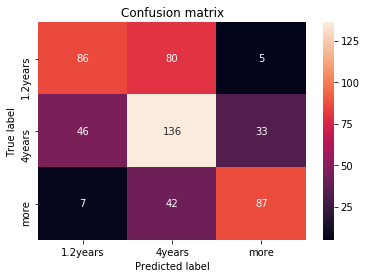

In [25]:
evaluation.plot_report(Y_test, l[np.argmax(probas, axis=1)], labels)

### Grid Search - I didn't run this on the three class problem 

In [27]:
from sklearn.model_selection import GridSearchCV

In [ ]:
# Create a model with 400 estimators for the grid search
rfc = RandomForestClassifier(random_state = 1233)


# Create the parameter grid based on the results of random search 
param_grid = {
    'bootstrap': [True, False],
    'max_depth': [80, 90, 100, 110],
    'max_features': [2, 3],
    'min_samples_leaf': [3, 4, 5],
    'min_samples_split': [8, 10, 12],
    "criterion": ["gini", "entropy"],
    "n_estimators": [10,20,50,100,300,400,500,1000,1500,2000]
}
#"max_features": ['auto','log2']


# Instantiate GRID SEARCH over the space of parameters defined 
# Should we play with CV? 
grid_search = GridSearchCV(estimator = rfc, param_grid=param_grid, 
                           n_jobs = -1, verbose = 2, # Do we need jobs and verbose to change?
                           scoring='neg_log_loss', cv = 3, return_train_score=True)

# Fit the model - should not show processing 
grid_search.fit(X_train, Y_train);

In [28]:
grid_search.best_params_

{'bootstrap': False,
 'criterion': 'gini',
 'max_depth': 80,
 'max_features': 3,
 'min_samples_leaf': 3,
 'min_samples_split': 8,
 'n_estimators': 500}

In [29]:
best_grid = grid_search.best_estimator_
#grid_accuracy = evaluate(best_grid, test_features, test_labels) - what is this one? what are the test_features? 
best_grid

RandomForestClassifier(bootstrap=False, class_weight=None, criterion='gini',
            max_depth=80, max_features=3, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=3, min_samples_split=8,
            min_weight_fraction_leaf=0.0, n_estimators=500, n_jobs=1,
            oob_score=False, random_state=1233, verbose=0,
            warm_start=False)

In [ ]:
# Compare to previous approach - I don't think this one is better (Fix helper)
#df = pd.DataFrame.from_dict(grid_search.cv_results_) 
#helper.write_to_pickle(df,"RandomForest_CV_400estimators")

In [ ]:
rfc=best_grid

rfc.fit(X_train, Y_train)



# Accuracy on test
accuracy = rfc.score(X_test,Y_test)
    
# XEntropy Error
probas = rfc_merge.predict_proba(X_test)
y_pred = np.argmax(probas, axis=1)
error = log_loss(Y_test,probas)

# Confusion matrix and report     
#cfm = confusion_matrix(Y_test, l[y_pred])
evaluation.plot_report(Y_test, l[y_pred], labels)

## Final Model for Random Forests
* If CV doesn't contain results, use previous Grid CV results
* If CV contains results, use them, but will only work on cloud

             precision    recall  f1-score   support

   1.2years       0.63      0.43      0.51       171
     4years       0.54      0.67      0.60       215
       more       0.70      0.69      0.69       136

avg / total       0.61      0.60      0.59       522

Accuracy: 0.5977011494252874
For 3 class problem --- Accuracy: 0.5977011494252874 and Logloss: 0.8472091430866424


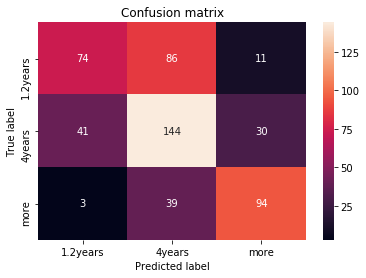

In [38]:
# Random forests with the right number of estimators based on validation set
# rfc = best result from above
rfc=RandomForestClassifier(bootstrap=False, class_weight=None, criterion='gini',
            max_depth=80, max_features=3, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=3, min_samples_split=8,
            min_weight_fraction_leaf=0.0, n_estimators=400, n_jobs=1,
            oob_score=False, random_state=1233, verbose=0,
            warm_start=False)
    
rfc.fit(X_train, Y_train)
    
score = rfc.score(X_test,Y_test)
    
# XEntropy Error
probas = rfc.predict_proba(X_test)
y_pred = rfc.predict(X_test)
#np.argmax(probas, axis=1)
error = log_loss(Y_test,probas)
    
# Confusion matrix      
#cfm = confusion_matrix(Y_test, l[y_pred])
evaluation.plot_report(Y_test, y_pred, labels)
   
print("For {0} class problem --- Accuracy: {1} and Logloss: {2}".format(len(labels), score, error))    
# ROC-AUC needs fixing.  
#Y_test_binary = label_binarize(Y_test, classes=labels)
#y_pred_binary = label_binarize(l[y_pred],classes =labels)
#auc_curve = evaluation.multi_class_auc(len(l),Y_test_binary,y_pred_binary)

# XGBoost Gradient Boosting 

In [33]:
from xgboost import XGBClassifier

## Baseline XGBoost

/Users/patricfulop/anaconda3/envs/cancer/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


             precision    recall  f1-score   support

   1.2years       0.63      0.49      0.55       171
     4years       0.53      0.67      0.59       215
       more       0.72      0.62      0.67       136

avg / total       0.61      0.60      0.60       522

Accuracy: 0.5977011494252874


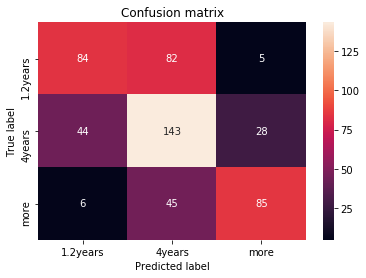

In [35]:
boost_model = XGBClassifier()
boost_model.fit(X_train, Y_train)
boost_model.score(X_test,Y_test)

probas = boost_model.predict_proba(X_test)
y_pred = np.argmax(probas, axis=1)
error = log_loss(Y_test,probas)

evaluation.plot_report(Y_test, l[y_pred], labels)

/Users/patricfulop/anaconda3/envs/cancer/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


For 3 class problem --- Accuracy: 0.5708812260536399 and Logloss: 0.9920421179947783
             precision    recall  f1-score   support

   1.2years       0.57      0.53      0.55       171
     4years       0.51      0.56      0.54       215
       more       0.68      0.63      0.66       136

avg / total       0.58      0.57      0.57       522

Accuracy: 0.5708812260536399


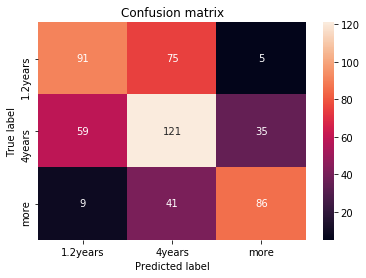

In [36]:
# Gradient Boosting classifiers based on validation/test
# What are the key aspects of tuning the XGBoost Tree
gbc = XGBClassifier(learning_rate= 0.03, 
                                 n_estimators=300,
                                 max_depth =30,                          
                                 random_state = 1123)
gbc.fit(X_train, Y_train)

# Accuracy
accuracy = gbc.score(X_test,Y_test)

# Error 
probas = gbc.predict_proba(X_test)
y_pred = np.argmax(probas, axis=1)
error = log_loss(Y_test,probas)
print("For {0} class problem --- Accuracy: {1} and Logloss: {2}".format(len(labels), accuracy, error))    
evaluation.plot_report(Y_test, l[y_pred], labels)

In [ ]:
#X_tr_merge = pd.concat((X_train,X_test)).as_matrix()
#Y_tr_merge = pd.concat((Y_train,Y_test)).as_matrix()

In [ ]:
#plt.figure()
#evaluation.plot_confusion_matrix(cfm, norm=True, classes=labels)
#plt.xlabel('Interpreted cluster label')
#plt.show()

In [32]:
#fig, ax = plt.subplots(1, 3, figsize=(15,10))

#ax[0].scatter(estimators_range, errors)
#ax[0].set_ylabel('Log-loss error on validation set')
#ax[0].set_xlabel('Number of estimators for Random Forest Classifier');

#ax[1].scatter(estimators_range, accuracies)
#ax[1].set_ylabel('Accuracies on validation set')
#ax[1].set_xlabel('Number of estimators for Random Forest Classifier');

#ax[2].scatter(estimators_range, roc_auc)
#ax[2].set_ylabel('AUC on validation set')
#ax[2].set_xlabel('Number of estimators for Random Forest Classifier');


## Miscellaneous - Exporting data to a tree style graph for interpretation

In [ ]:
# Feature importance in descending order
feat_order_ind = np.argsort(rf_ind.feature_importances_)[::-1] # In descending order
print('50 most important features in order of decreasing importance: \n{}'.
      format(train_A.drop(["imgId", "is_person"], axis=1).columns[feat_order_ind[0:50]]))

title = 'Learning Curves (NN with tuned hyperparameters)'    
estimator = nn01_opt # regressor with tuned hyperparameters 
plot_learning_curve(estimator, title, sine_X_train, sine_y_train, 
                    ylim=(-10., 0.), cv=5, n_jobs=-1, scoring='mean_squared_error')
plt.grid(True)
plt.show()

########### 

dot_data = tree.export_graphviz(dt, out_file=None, 
    feature_names= df_clean.drop(["life_expectancy_bin","life_expectancy"], axis=1).columns,  
    class_names = labels,  
    filled=True, rounded=True,  
    special_characters=True)
graph = graphviz.Source(dot_data)
graph
#To create a file do this:
#To create a file do this:
with open("tree.dot", 'w') as f:
     f = export_graphviz(dt, out_file=f,
                         feature_names = df_clean.drop(["life_expectancy_bin","life_expectancy"], axis=1).columns,  
                         class_names = labels,   
                         filled=True, rounded=True,  
                         special_characters=True)